## Starting Point

A pricing model we want to replicate with a neural network.

## Motivation

The belief that the neural network will cost less compute to train and predict prices (RFQs) faster than the full model. The use case will target complex path dependant (montecarlo) models that have a high compute cost and are relativly slow.

In [2]:
#
# Some set-up for the NN environment, for this we are using TensorFlow and Keras.
#
import tensorflow as tf
import numpy as np
import random
import inspect
import time
import re
from enum import Enum
from typing import Tuple, List, Union, Callable
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from itertools import permutations
import pandas as pd

In [3]:
#
# This is so we can visualise results
#
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Simple Model

For the purpose of experimenting with the process we define a simple Black Scholes option model. This will allow us to show the work flow and highlight the challenges with the approach.

The specific model implementation below is arbitrary, it is just a means to show how the neural network can learn a function of the same order of magnitude of complexity as a simple option contract.

In [473]:
def black_scholes_model(S: float,
                        K: float,
                        T: float,
                        r: float,
                        v: float,
                        o: float = float(0)) -> float:
    """
    Implementation of Black Scholes model.

    Trivial example to demo of proof of concept for fitting an option pricing model
    with a neural network.

    :param S: Spot
    :param K: Strike
    :param T: Time to maturity
    :param r: risk free rate
    :param v: underlying volatility
    :param o: type, call = 0 or put = 1
    :return: Option Price
    """
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))

    if o == 0.0:
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if o == 1.0:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    assert False, "Option must be call=0 or put=1"

## Pricing Scenarios

In the real use case we will collect the back history  RFQ ( (request for quote) as training data for the neural network. This presents the first challenge as to train the model we need a spread of data across all combinations of all parameters and instrument details that impact the price we are trying to predict. If we have gaps in our training data there will also be a weakness in the model when predicting prices with that specific combination of inputs.

The nature of neural networks is to give results, even an totally untrained neural network will make predictions, just erroneous ones. So we will need to review the spread of inputs we have and make sure (expert judgment) that there are sufficient examples for all of teh combinations we are likely to quote. If the markets shift significantly we can also add additional training data, but we must be aware when the model is being asked to make predictions outside of its experience.

In this example we will create training data from scratch by running scenarios by varying the input parameters and capturing the results.

In [474]:
def parameter_scenarios(vol_range: Tuple[float, float] = (0.01, 0.4),
                        mat_range: Tuple[float, float] = (1e-6, 1.0),
                        spot_range: Tuple[float, float] = (1.0, 100.0),
                        strike_range: Tuple[float, float] = (1.0, 100.0),
                        rate_range: Tuple[float, float] = (0.01, 0.25),
                        num_steps=50) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    Create scenario vectors for volatility, maturity, spot, strike and risk-free rate

    :param vol_range: The range to vary volatility over
    :param mat_range: The range to vary maturity over
    :param spot_range: The range to vary spot over
    :param strike_range: The range to vary strike over
    :param rate_range: The range to vary risk-free rate over
    :param num_steps: number of scenario steps
    :return: volatility, maturity, spot, strike and risk-free rate scenarios as list of float
    """
    vols = [vol_range[0] + (x * ((vol_range[1] - vol_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    mats = [mat_range[0] + (x * ((mat_range[1] - mat_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    spots = [spot_range[0] + (x * ((spot_range[1] - spot_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    strikes = [strike_range[0] + (x * ((strike_range[1] - strike_range[0]) /
                                  (num_steps - 1))) for x in range(num_steps)]
    rates = [rate_range[0] + (x * ((rate_range[1] - rate_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    return vols, mats, spots, strikes, rates

In [475]:
def combinations(list1: Union[List[float], float], list2: Union[List[float], float]) -> List:
    """
    Return all combinations of the given lists

    :param list1: The first list
    :param list2: The second list
    :return: List of all combinations of lists 1 and List 2
    """
    if not isinstance(list1, List):
        list1 = [list1]
    if not isinstance(list2, List):
        list2 = [list2]
    res = []
    for x in list1:
        for y in list2:
            if not isinstance(x, List):
                x = [x]
            if not isinstance(y, List):
                y = [y]
            res.append([*x, *y])
    return res

In [476]:
def generate_model_scenarios(spot: Union[List[float], float],
                             strike: Union[List[float], float],
                             mat: Union[List[float], float],
                             rate: Union[List[float], float],
                             vol: Union[List[float], float]
                             ) -> List[Tuple[float, float, float, float, float]]:
    """
    Return a set of model scenario inputs based on given parameter scenarios

    :param vol: List of volatilities or single volatility
    :param vol: List of maturities or single maturity
    :param vol: List of spots or single spot
    :param vol: List of strike or single strike
    :param vol: List of rates or single rate
    :return: List of all combinations [[s,k,t,r,v]]
    """
    return combinations(combinations(combinations(combinations(spot, strike), mat), rate), vol)

In [477]:
def two_d_scenario(spot: Union[List[float], float],
                   strike: Union[List[float], float],
                   mat: Union[List[float], float],
                   rate: Union[List[float], float],
                   vol: Union[List[float], float],
                   price_func: Callable,
                   scaler=None) -> Tuple[List[float], str, List[float], str, np.ndarray]:

    """
    Generate a scenario where two of the given parameters are scenarios

    :param spot: spot scenario or single spot
    :param strike: strike scenario or single strike
    :param maturity: maturity scenario or single maturity
    :param rate: rate scenario or single rate
    :param vol: volatility scenario or single volatility
    :param price_func: The pricing function, either black_scholes or model.predict
    :param scaler: The scaler used to normalise the model inputs
    :return: scenario List 1, scenario parameter 1 name, scenario List 2, scenario parameter 2 name, scenario prices

    """
    params = [spot, strike, mat, rate, vol]
    arg_names = [*inspect.signature(black_scholes_model).parameters.keys()]
    scenario_params = [[x[0][0], x[0][1], x[1]] for x in zip(
        enumerate(params), arg_names) if isinstance(x[0][1], List)]
    assert (len(scenario_params) ==
            2), "Only two parameters can be passed as scenario lists"
    prices = np.zeros((len(scenario_params[0][1]), len(scenario_params[1][1])))
    for i, x in enumerate(scenario_params[0][1]):
        if scaler is None: # cell by cell
            for j, y in enumerate(scenario_params[1][1]):
                params[scenario_params[0][0]] = x
                params[scenario_params[1][0]] = y
                prices[i, j] = (price_func)(*params)
        else: # row by row as it is quicker when calling model.predict
            params[scenario_params[0][0]] = x
            params[scenario_params[1][0]] = None
            param_set = np.tile(np.asarray(params),
                                (len(scenario_params[1][1]), 1))
            param_set[:, scenario_params[1][0]] = scenario_params[1][1]
            param_set = scaler.transform(param_set)
            prices[i, :] = ((price_func)(param_set.astype(np.float64))).reshape(
                1, len(scenario_params[1][1]))
        print("{:0.0f} % Complete".format(
            100 * ((i*len(scenario_params[1][1]))/prices.size)))
    print("Done")
    return scenario_params[0][1], scenario_params[0][2],  scenario_params[1][1], scenario_params[1][2], prices

### Step 1. Generate parameter scenarios

Generate a range for each model paramater type. These will be used to generate training data by calling the model for each combination of the parameters.

In a real case we would try to collect this data as a side effect of where the real model was being used and only augment the training set where we observed gaps or thin spots in the training data

In [ ]:
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)

In [ ]:
Y = [black_scholes_model(*params) for params in X]

In [ ]:
dfy = pd.DataFrame(Y, columns=['price'])
dfx = pd.DataFrame(X, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfRaw = dfx.join(dfy)

In [ ]:
dfRaw.to_csv('XYRaw', encoding='ascii', index=False)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1),copy=False).fit(X)
XScaled = scaler.transform(X)
dfxs = pd.DataFrame(XScaled, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfScaled = dfxs.join(dfy)

In [ ]:
dfScaled.to_csv('XYScaled', encoding='ascii', index=False)

### Step 3. Create a neural network that can be regression trained to predict the price.

This is where art meet science in that there are not hard and fast rules for the size, shape and architecture of a neural network that will be able to converge on a general form of teh function in a given set of data (if one exists). There are guidelines and many types of layer that fit certain patterns for image processing etc, so there is always informed experimentation at this stage.

This is a very simple model as the data set is relatively small, however even a simple data set such as this took a number of experiments to get the right balance.

In [ ]:
def create_neural_net():
    """
    Create a Neural network with an architecture tuned to regression.
    """

    # Create a NN of 5 Dense layers, with 5 inputs (number of BS parameters) abd a single
    # output that predicts the price for the given parameters
    model = Sequential()

    model.add(Dense(32, input_shape=(5,),
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(16,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(4,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(2,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1,
                    kernel_initializer='normal', activation='linear'))

    # Print the model architecture out
    model.summary()

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

### Step 5. Shuffle the training data & split into Test & Train data sets

1. The training data is shuffled to improve training accuracy
2. Split out a third of the data as a validation set
3. Ensure all training and test data is pur numpy arrays (not always the case after using pipeline transforms)

In [ ]:
class ModelType(Enum):
    NEURAL_NET = 1
    RANDOM_FOREST_REGRESSOR = 2


def fit(X: np.ndarray,
        Y: np.ndarray,
        model_type: ModelType):
    """
    Prepare the model inputs and fit the data with the given model type.
    
    :param X: Pricing parameter scenarios
    :param Y: Prices corresponding to given inputs
    :return : The tf model, training history & test and training data used X_train, Y_train, X_test, Y_test

    """

    # Shuffle & scale the data

    X = XScaled
    Xs, Ys = shuffle(X, Y, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.33)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    # Create a check point to save the model version with the best validation loss

    saveBest = ModelCheckpoint(filepath='best',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               mode='min')

    # Fit to the requested type

    if model_type == ModelType.NEURAL_NET:
        print("Create and fit Neural Network")
        model = create_neural_net()
        history = model.fit(X_train, Y_train,
                            batch_size=256,
                            epochs=50,
                            verbose=1,
                            validation_data=(X_test, Y_test),
                            callbacks=[saveBest])
        model.load_weights('best') # load back the model corresponding to lowest validation loss
    elif model_type == ModelType.RANDOM_FOREST_REGRESSOR:
        print("Create and fit Random Forest Regressor")
        model = RandomForestRegressor(n_estimators=250, verbose=2)
        model.fit(X_train, Y_train)
        history = None
    else:
        assert False, "Invalid model type specified, see model types defined by class ModelType"

    mse = mean_squared_error(model.predict(X_test), Y_test)
    print(f"Final Mean Square Error [{mse:5f}]")
    return model, history, X_train, Y_train, X_test, Y_test

### Step 6. Train the model but fitting to the given training data

In [ ]:
model, history,X_train, Y_train, X_test, Y_test = fit(X, Y, ModelType.NEURAL_NET)

In [ ]:
def plot_training_history(loss,
                          validation_loss, 
                          skip=0):
    """
    Plot a two axis line graph of training and validation losses
    
    :param loss: Training losses per epoch
    :param validation_ loss: Validation losses per epoch
    :param skip: don't plot the first skip points

    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Validation Loss', color='b')
    ax1.plot(loss[skip:], color='r')
    ax2.plot(validation_loss[skip:], color='b')
    plt.show()

### Step 7. Examine the training losses and verify if model has learned a generalisation of the option function.

We expect to see the Loss (red line) drop off exponentially as the model learns (fits) the data and the error between actual and predicted reduces.

The validation loss (blue line) should also drop off as the model get better at predicting for test data (hold out) that it has not seen during training. If the loss increases, this is an indication that the model is too powerful and has just learned the training data (over fitted) rather than fitting a generalised form of the function in the training data.

In [ ]:
if history is not None:
    plot_training_history(history.history['loss'],
                          history.history['val_loss'],
                          skip=9)

### Step 8. Generate a result set based on direct model calls.

We generate a set of prices based on direct model calls so we can plot a pricing surface and see what the function looks like. This then also acts as the target surface we expect to see when we predict and plot the prices with the model


In [ ]:
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)

In [ ]:
# Rate vs Vol Scenario
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=model.predict, scaler=scaler)

In [ ]:
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=model.predict, scaler=scaler)

In [ ]:
s1,s1n,s2,s2n,actual = two_d_scenario(spot=spots, strike=strikes, mat=1.0, rate=0.05,vol=.2, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=spots, strike=strikes, mat=1.0, rate=0.05,vol=0.2, price_func=model.predict, scaler=scaler)

In [ ]:
def plot_price_surface(xscen,
                       yscen,
                       actual,
                       predicted,
                       title,
                       xscen_lab,
                       yscen_lab):
    """
    Plot dual surface of actual vs predicted, with a contour plot of price difference as %
    """
    minz = min(np.min(actual), np.min(predicted))
    maxz = max(np.max(actual), np.max(predicted))

    X, Y = np.meshgrid(xscen, yscen)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim3d(minz, maxz)
    c1 = ax.contourf(X, Y, ((actual-predicted)/np.maximum(1e-9,actual))*100.0,
                     levels=range(-100, 100, 1), cmap=cm.RdGy, offset=np.min(minz))
    s1 = ax.plot_surface(X, Y, actual, cmap=cm.coolwarm,
                         linewidth=0, edgecolor='none', alpha=.7)
    s2 = ax.plot_surface(X, Y, predicted, edgecolors='k',
                         linewidth=0.1, color='gray', alpha=.3)
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0 +
                       ((ax.get_position().height)*0.15), 0.02, (ax.get_position().height)*0.7])
    cb = fig.colorbar(c1, cax=cax)
    cb.ax.set_ylabel('% difference', rotation=270)
    ax.set_xlabel(xscen_lab)
    ax.set_ylabel(yscen_lab)
    ax.set_zlabel("Option Price")
    ax.set_title(title)
    plt.show()

## Actual vs Predicted

### Surface

We plot the actuals as a surface (blue-red) and then overlay the predicted as a translucent gray surface, so we can see where the two diverge. We also plot a contour of the % difference at every point.

In [ ]:
plot_price_surface(vols, mats, actual, predicted, title="Predicted vs Actual Comparison",
                   xscen_lab=s1n, yscen_lab=s2n)

### Scatter 
If we scatter plot actual vs predicted then we would expect to see a straight line, as for any given scenario point the actual and predicted would be equal.

In [ ]:
plt.scatter(actual.flatten(), predicted.flatten(), s=0.25)

In [466]:
#
# https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/black_scholes/crr_binomial_tree_test.py
#

def _get_payoff_fn(strikes, is_call_options):
    """Constructs the payoff functions."""
    option_signs = tf.cast(is_call_options, dtype=strikes.dtype) * 2 - 1

    def payoff(spots):
        """Computes payff for the specified options given the spot grid.

        Args:
          spots: Tensor of shape [batch_size, grid_size, 1]. The spot values at some
            time.

        Returns:
          Payoffs for exercise at the specified strikes.
        """
        return tf.nn.relu((spots - strikes) * option_signs)

    return payoff


def _get_value_modifier(is_american, payoff_fn):
    """Constructs the value modifier for american style exercise."""

    def modifier(values, spots):
        immediate_exercise_value = payoff_fn(spots)
        return tf.where(is_american,
                        tf.math.maximum(immediate_exercise_value, values), values)

    return modifier


def option_price_binomial(*,
                          volatilities,
                          strikes,
                          expiries,
                          spots,
                          discount_rates=None,
                          dividend_rates=None,
                          is_call_options=None,
                          is_american=None,
                          num_steps=100,
                          dtype=None,
                          name=None):
    """Computes the BS price for a batch of European or American options.

    Uses the Cox-Ross-Rubinstein version of the binomial tree method to compute
    the price of American or European options. Supports batching of the options
    and allows mixing of European and American style exercises in a batch.
    For more information about the binomial tree method and the
    Cox-Ross-Rubinstein method in particular see the references below.

    #### Example

    ```python
    # Prices 5 options with a mix of Call/Put, American/European features
    # in a single batch.
    dtype = np.float64
    spots = np.array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=dtype)
    strikes = np.array([3.0, 3.0, 3.0, 3.0, 3.0], dtype=dtype)
    volatilities = np.array([0.1, 0.22, 0.32, 0.01, 0.4], dtype=dtype)
    is_call_options = np.array([True, True, False, False, False])
    is_american = np.array([False, True, True, False, True])
    discount_rates = np.array(0.035, dtype=dtype)
    dividend_rates = np.array([0.02, 0.0, 0.07, 0.01, 0.0], dtype=dtype)
    expiries = np.array(1.0, dtype=dtype)

    prices = option_price_binomial(
        volatilities=volatilities,
        strikes=strikes,
        expiries=expiries,
        spots=spots,
        discount_rates=discount_rates,
        dividend_rates=dividend_rates,
        is_call_options=is_call_options,
        is_american=is_american,
        dtype=dtype)
    # Prints [0., 0.0098847, 0.41299509, 0., 0.06046989]
    ```

    #### References

    [1] Hull, John C., Options, Futures and Other Derivatives. Pearson, 2018.
    [2] Wikipedia contributors. Binomial Options Pricing Model. Available at:
      https://en.wikipedia.org/wiki/Binomial_options_pricing_model

    Args:
      volatilities: Real `Tensor` of any shape and dtype. The volatilities to
        expiry of the options to price.
      strikes: A real `Tensor` of the same dtype and compatible shape as
        `volatilities`. The strikes of the options to be priced.
      expiries: A real `Tensor` of same dtype and compatible shape as
        `volatilities`. The expiry of each option. The units should be such that
        `expiry * volatility**2` is dimensionless.
      spots: A real `Tensor` of any shape that broadcasts to the shape of the
        `volatilities`. The current spot price of the underlying.
      discount_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. The risk free discount rate. If None the rate is assumed
        to be 0.
        Default value: None, equivalent to discount rates = 0..
      dividend_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. If None the rate is assumed to be 0.
        Default value: None, equivalent to discount rates = 1.
      is_call_options: A boolean `Tensor` of a shape compatible with
        `volatilities`. Indicates whether the option is a call (if True) or a put
        (if False). If not supplied, call options are assumed.
        Default value: None, equivalent to is_call_options = True.
      is_american: A boolean `Tensor` of a shape compatible with `volatilities`.
        Indicates whether the option exercise style is American (if True) or
        European (if False). If not supplied, European style exercise is assumed.
        Default value: None, equivalent to is_american = False.
      num_steps: A positive scalar int32 `Tensor`. The size of the time
        discretization to use.
        Default value: 100.
      dtype: Optional `tf.DType`. If supplied, the dtype to be used for conversion
        of any supplied non-`Tensor` arguments to `Tensor`.
        Default value: None which maps to the default dtype inferred by TensorFlow
          (float32).
      name: str. The name for the ops created by this function.
        Default value: None which is mapped to the default name `option_price`.

    Returns:
      A `Tensor` of the same shape as the inferred batch shape of the input data.
      The Black Scholes price of the options computed on a binomial tree.
    """
    with tf.name_scope(name or 'crr_option_price'):
        strikes = tf.convert_to_tensor(strikes, dtype=dtype, name='strikes')
        dtype = strikes.dtype
        volatilities = tf.convert_to_tensor(
            volatilities, dtype=dtype, name='volatilities')
        expiries = tf.convert_to_tensor(expiries, dtype=dtype, name='expiries')
        spots = tf.convert_to_tensor(spots, dtype=dtype, name='spots')

        if discount_rates is None:
            discount_rates = tf.zeros_like(volatilities)
        else:
            discount_rates = tf.convert_to_tensor(
                discount_rates, dtype=dtype, name='discount_rates')
        if dividend_rates is None:
            dividend_rates = tf.zeros_like(volatilities)
        else:
            dividend_rates = tf.convert_to_tensor(
                dividend_rates, dtype=dtype, name='dividend_rates')
        if is_call_options is None:
            is_call_options = tf.ones_like(
                volatilities, dtype=tf.bool, name='is_call_options')
        else:
            is_call_options = tf.convert_to_tensor(
                is_call_options, dtype=tf.bool, name='is_call_options')
        if is_american is None:
            is_american = tf.zeros_like(
                volatilities, dtype=tf.bool, name='is_american')
        else:
            is_american = tf.convert_to_tensor(
                is_american, dtype=tf.bool, name='is_american')

        num_steps = tf.cast(num_steps, dtype=dtype)
        dt = expiries / num_steps

        # CRR choices for the up and down move multipliers
        ln_up = volatilities * tf.math.sqrt(dt)
        ln_dn = -ln_up

        # Prepares the spot grid.
        grid_idx = tf.range(num_steps + 1)
        # Stores the grid as shape [input_batch, N + 1] where N = num_steps.
        log_spot_grid_1 = tf.expand_dims(
            tf.math.log(spots) + ln_up * num_steps, axis=-1)
        log_spot_grid_2 = tf.expand_dims(ln_dn - ln_up, axis=-1) * grid_idx
        log_spot_grid = log_spot_grid_1 + log_spot_grid_2

        # Adding the new dimension is to ensure that batch shape is at the front.
        payoff_fn = _get_payoff_fn(
            tf.expand_dims(strikes, axis=-1),
            tf.expand_dims(is_call_options, axis=-1))
        value_mod_fn = _get_value_modifier(
            tf.expand_dims(is_american, axis=-1), payoff_fn)

        # Shape [batch shape, num time steps + 1]
        values_grid = payoff_fn(tf.math.exp(log_spot_grid))

        p_up = tf.math.exp((discount_rates - dividend_rates) * dt + ln_up) - 1
        p_up /= tf.math.exp(2 * ln_up) - 1
        p_up = tf.expand_dims(p_up, axis=-1)
        p_dn = 1 - p_up
        discount_factors = tf.expand_dims(
            tf.math.exp(-discount_rates * dt), axis=-1)
        ln_up = tf.expand_dims(ln_up, axis=-1)

        def one_step_back(current_values, current_log_spot_grid):
            next_values = (current_values[..., 1:] * p_dn
                           + current_values[..., :-1] * p_up)
            next_log_spot_grid = current_log_spot_grid[..., :-1] - ln_up
            next_values = value_mod_fn(
                next_values, tf.math.exp(next_log_spot_grid))
            return discount_factors * next_values, next_log_spot_grid

        def should_continue(current_values, current_log_spot_grid):
            del current_values, current_log_spot_grid
            return True

        batch_shape = values_grid.shape[:-1]
        pv, _ = tf.while_loop(
            should_continue,
            one_step_back, (values_grid, log_spot_grid),
            maximum_iterations=tf.cast(num_steps, dtype=tf.int32),
            shape_invariants=(tf.TensorShape(batch_shape + [None]),
                              tf.TensorShape(batch_shape + [None])))
        return tf.where(
            expiries > 0,
            tf.squeeze(pv, axis=-1),
            tf.where(is_call_options,
                     tf.math.maximum(spots - strikes, 0),
                     tf.math.maximum(strikes - spots, 0)))

In [560]:
f = open("training.csv", "w")
res = []
v = 0.05
for i in range(100):
    v += 0.05
    res.append(np.float64(option_price_binomial(volatilities=v,
                          strikes=3.0,
                          expiries=1.0,
                          spots=3.0,
                          discount_rates=0.035,
                          dividend_rates=0.07,
                          is_call_options=False,
                          is_american=True,
                          num_steps=100,
                          dtype=np.float64)))
print(res)

[0.1699267589940286, 0.22419338410832115, 0.27947430480342916, 0.3350718963982805, 0.3907371360544206, 0.4463589186673278, 0.5018749896652677, 0.5572363255359198, 0.6123942932159053, 0.6673005523763282, 0.7219052333521736, 0.776162744472108, 0.8300287327698597, 0.8834658721052184, 0.9364377846765696, 0.9889081466594429, 1.0408480849646695, 1.0922265807867197, 1.1430165411350965, 1.1931903646279234, 1.2427291720106817, 1.291603605773916, 1.339790756501213, 1.387275286714091, 1.4340390849318905, 1.4800596333505922, 1.5253240154592846, 1.5698174654680344, 1.6135241157526323, 1.6564328711166654, 1.6985321302942271, 1.7398117684361327, 1.7802637884970618, 1.8198792816149245, 1.8586521678618269, 1.8965804962225965, 1.9336568537868042, 1.969878056707479, 2.0052458176720185, 2.0397587672670374, 2.0734164203007333, 2.106220060976816, 2.1381731773956556, 2.1692798133666504, 2.199543674124456, 2.2289719642530557, 2.2575699847630193, 2.2853443050259523, 2.31230183219203, 2.3384539607824784, 2.3638

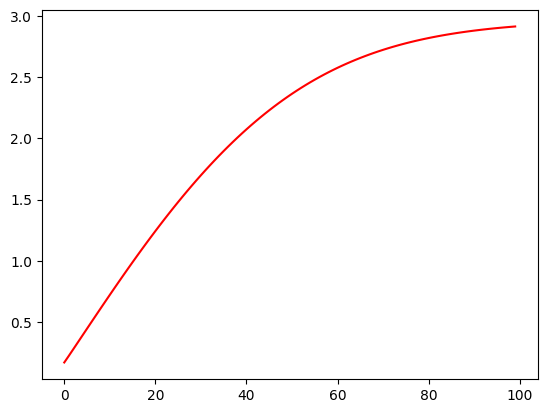

In [561]:
fig, ax1 = plt.subplots()
ax1.plot(res, color='r')
plt.show()

## Extend feature set

We need to extend the feature set to cover the option style, Call or Put and early exercise or not, American or European

These string features needed encoding as numerical values so they can be passed to the model.

In [478]:
# Generate features without type and style.
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)

In [479]:
# Create all combinations with option type
# Call = 0, Put = 1
X = combinations(X, [0, 1])

In [480]:
# Create all combinations with option style
# American (early exercise) = 0, European = 1
X = combinations(X, [0, 1])

In [481]:
# Shuffle the training data
Xs = shuffle(X, random_state=42)
#scaler = MinMaxScaler(feature_range=(0, 1),copy=False).fit(Xs)
#Xss = scaler.transform(Xs)
dfxs = pd.DataFrame(Xs, columns=['spot', 'strike', 'maturity', 'rate', 'volatility','call_put','amer_eur'])
dfxs.to_csv('XFull.csv', encoding='ascii', index=False)

In [ ]:
!dir

In [563]:
def run_scenarios(X_train):

    res = []
    for scen in X_train:
        S, K, T, r, v, cp, ae = np.round(scen, 8)
        value = np.round(option_price_binomial(volatilities=v,
                                               strikes=K,
                                               expiries=T,
                                               spots=S,
                                               discount_rates=r,
                                               dividend_rates=0.0,
                                               is_call_options=not (bool(cp)),
                                               is_american=not (bool(ae)),
                                               num_steps=200,
                                               dtype=np.float64), 8)
        res.append([S, K, T, r, v, cp, ae, value])
    return res

In [ ]:
# Create a new CSV file for results and write a header row.
f = open("binomial_training.csv", "w")
f.write(f"Spot, Strike, Maturity, rate, volatility, isPut, isEuropean\n")
f.close()

In [ ]:
# Iterate over the pre-shuffled pandas X_train data in blocks, writing results out as we
# go. There are millions of training examples, so we want to make sure results are saved
# down. So, fo each block we flush, close and re-open the file in append mode.
base = 691000
sz = 500
all = len(dfxs)

while base < all:
    # Open in append.
    f = open("binomial_training.csv", "a")

    pdx = dfxs.iloc[base:base+sz]
    X_train = (pdx).to_numpy()
    results = run_scenarios(X_train)
    for r in results:
        S, K, T, r, v, cp, ae, p = r
        f.write(f"{S},{K},{T},{r},{v},{cp},{ae},{p}\n")
    f.flush()
    f.close()
    base = base + sz
    print(f"{base} of {all}")

In [14]:
def split_file(filename:str, size_in_MB:int=100) ->None:
    """
    split the given file into smaller files of the given size
    
    :param filename     : The name of the file to split
    :param size_in_MB   : Size in MB of the chunked files
    
    :credit to: https://stackoverflow.com/users/239247/anatoly-techtonik
    """
    MAX  = size_in_MB*1024*1024  # 500Mb  - max chapter size
    BUF  = 50*1024*1024*1024  # 50GB   - memory buffer size
    chapters = 0
    uglybuf  = ''
    with open(filename, 'rb') as src:
        while True:
            tgt = open(filename + '.%03d' % chapters, 'wb')
            written = 0
            while written < MAX:
                if len(uglybuf) > 0:
                    tgt.write(uglybuf)
                tgt.write(src.read(min(BUF, MAX - written)))
                written += min(BUF, MAX - written)
                uglybuf = src.read(1)
                if len(uglybuf) == 0:
                    break
            tgt.close()
            if len(uglybuf) == 0:
                break
            chapters += 1
    return

In [15]:
split_file("binomial_training_copy.csv")